<p style="background-color:#45B39D; color:white; padding:10px;">
  <b style="font-size: 16px;">📌 Importing Libraries</b>
</p>

In [115]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report

In [42]:
df=pd.read_csv('/content/Airline_Delay_Cause.csv')
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,...,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,5,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",136.0,7.0,5.95,0.00,...,0.0,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0
1,2022,5,9E,Endeavor Air Inc.,ABY,"Albany, GA: Southwest Georgia Regional",91.0,16.0,7.38,0.00,...,0.0,6.09,0.0,0.0,884.0,351.0,0.0,81.0,0.0,452.0
2,2022,5,9E,Endeavor Air Inc.,ACK,"Nantucket, MA: Nantucket Memorial",19.0,2.0,0.13,0.00,...,0.0,0.88,1.0,0.0,138.0,4.0,0.0,106.0,0.0,28.0
3,2022,5,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",88.0,14.0,7.26,0.76,...,0.0,1.64,0.0,0.0,947.0,585.0,35.0,125.0,0.0,202.0
4,2022,5,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",181.0,19.0,13.84,0.00,...,0.0,2.09,0.0,0.0,808.0,662.0,0.0,87.0,0.0,59.0


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318017 entries, 0 to 318016
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 318017 non-null  int64  
 1   month                318017 non-null  int64  
 2   carrier              318013 non-null  object 
 3   carrier_name         318013 non-null  object 
 4   airport              318014 non-null  object 
 5   airport_name         318017 non-null  object 
 6   arr_flights          317524 non-null  float64
 7   arr_del15            317285 non-null  float64
 8   carrier_ct           317525 non-null  float64
 9   weather_ct           317523 non-null  float64
 10  nas_ct               317529 non-null  float64
 11  security_ct          317529 non-null  float64
 12  late_aircraft_ct     317529 non-null  float64
 13  arr_cancelled        317529 non-null  float64
 14  arr_diverted         317527 non-null  float64
 15  arr_delay        

### 🔧 Data Cleaning Function

The `cleaned_data()` function is designed to prepare the dataset for analysis by performing the following steps:

- **Column Removal**: Drops unnecessary columns related to carrier and airport names:
  - `'carrier'`
  - `'carrier_name'`
  - `'airport'`
  - `'airport_name'`

- **Missing Values Handling**: Removes any rows that contain missing (`NaN`) values using `dropna()`.

- **Returns**: A cleaned version of the DataFrame with only the relevant and complete data.

In [44]:
def cleaned_data(data):
  df=data.drop(['carrier','carrier_name','airport','airport_name'],axis=1)
  clean_data=df.dropna()
  return clean_data

### 📥 Applying the Cleaning Function

We apply the `cleaned_data()` function to our original DataFrame `df`, and store the cleaned result in a new variable called `data`.


In [45]:
data=cleaned_data(df)

### 👀 Previewing the Cleaned Data

We use `data.head()` to display the first five rows of the cleaned dataset.

In [46]:
data.head()

,year,month,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2022,5,136.0,7.0,5.95,0.00,0.05,0.0,1.00,0.0,0.0,255.0,222.0,0.0,4.0,0.0,29.0
1,2022,5,91.0,16.0,7.38,0.00,2.54,0.0,6.09,0.0,0.0,884.0,351.0,0.0,81.0,0.0,452.0
2,2022,5,19.0,2.0,0.13,0.00,1.00,0.0,0.88,1.0,0.0,138.0,4.0,0.0,106.0,0.0,28.0
3,2022,5,88.0,14.0,7.26,0.76,4.35,0.0,1.64,0.0,0.0,947.0,585.0,35.0,125.0,0.0,202.0
4,2022,5,181.0,19.0,13.84,0.00,3.07,0.0,2.09,0.0,0.0,808.0,662.0,0.0,87.0,0.0,59.0


In [50]:
data['arr_cancelled'].value_counts()

,count
arr_cancelled,
0.0,129457
1.0,47833
2.0,29190
3.0,19800
4.0,14225
...,...
1210.0,1
825.0,1
561.0,1


### 🏷️ Creating a Binary Target Column: `is_canceled`

We create a new binary column called `is_canceled` from the original `arr_cancelled` column:

In [52]:
data['is_canceled']=data['arr_cancelled'].apply(lambda x: 1 if x>0 else 0)

### ⚖️ Target Class Distribution

The binary target column `is_canceled` has the following value counts:

- `1` (Canceled): 187,811 samples
- `0` (Not Canceled): 129,457 samples

This indicates that the dataset is **imbalanced**, with more canceled flights than non-canceled ones.  
Before training a classification model, it’s important to address this imbalance using techniques like:
- **SMOTE (Synthetic Minority Over-sampling Technique)**
- **Class weights adjustment**
- **Resampling strategies**

In [53]:
data['is_canceled'].value_counts()

,count
is_canceled,
1,187811
0,129457


In [57]:
x=data.drop(['is_canceled'],axis=1)
y=data['is_canceled']

In [58]:
smote=SMOTE(sampling_strategy='minority')
x,y=smote.fit_resample(x,y)
y.value_counts()

,count
is_canceled,
0,187811
1,187811


### Data Splitting

The dataset was split into training and testing sets using `train_test_split` with the following configuration:
- **Test size**: 25% of the data
- **Random state**: 44 (to ensure reproducibility)
- **Shuffle**: Enabled (to randomize the data before splitting)

After splitting:
- **X_train** shape: (281,716, 17) → 281,716 training samples with 17 features each
- **X_test** shape: (93,906, 17) → 93,906 testing samples with 17 features each
- **y_train** shape: (281,716,) → target labels for training
- **y_test** shape: (93,906,) → target labels for testing


In [60]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=44,shuffle=True)

In [62]:
print('X_train shape is ' , x_train.shape)
print('X_test shape is ' , x_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (281716, 17)
X_test shape is  (93906, 17)
y_train shape is  (281716,)
y_test shape is  (93906,)



<p style="background-color:#45B39D; color:white; padding:10px;">
  <b style="font-size: 16px;">  ⏳Create Model</b>
</p>

### Model Architecture

The model is built using the Keras Sequential API with the following layers:

- **Input layer**: The input shape is inferred automatically from the training data.
- **Dense layer 1**: 8 neurons with `'tanh'` activation.
- **Dense layer 2**: 128 neurons with `'sigmoid'` activation.
- **Dense layer 3**: 32 neurons with `'tanh'` activation.
- **Dropout layer**: 20% dropout to prevent overfitting.
- **Output layer**: 1 neuron with `'sigmoid'` activation (suitable for binary classification).

This architecture mixes `tanh` and `sigmoid` activations and uses dropout regularization to reduce overfitting risk.

In [64]:
model=keras.models.Sequential([
    keras.layers.Dense(8,activation='tanh'),
    keras.layers.Dense(128,activation='sigmoid'),
    keras.layers.Dense(32,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1,activation='sigmoid')
])

### Optimizer Description

In this step, we define the optimizer used to train the neural network model. We chose **AdamW**, which is a variant of the Adam optimizer that includes **weight decay (L2 regularization)** to improve generalization and reduce overfitting.

The optimizer is initialized with the following parameters:
- **learning_rate=0.001**: Controls how much the weights are updated during training.
- **weight_decay=0.004**: Adds L2 penalty to the loss function to discourage large weights.
- **beta_1=0.9**: Exponential decay rate for the first moment estimates (mean of gradients).
- **beta_2=0.999**: Exponential decay rate for the second moment estimates (variance of gradients).

Using `AdamW` helps stabilize and speed up the training process, especially for deep neural networks.


In [68]:
MyOptimizer = tf.keras.optimizers.AdamW(
    learning_rate=0.001,
    weight_decay=0.004,
    beta_1=0.9,
    beta_2=0.999
)


### Model Compilation

In this step, we compile the model by specifying the optimizer, loss function, and evaluation metrics:

- **optimizer=MyOptimizer**: We use the previously defined `AdamW` optimizer to update the model weights.
- **loss='binary_crossentropy'**: This loss function is used for binary classification problems. It measures the difference between the predicted probability and the actual label (0 or 1).
- **metrics=['accuracy']**: During training and evaluation, the model will report accuracy, which measures the percentage of correct predictions.

This compilation setup is suitable for binary classification tasks and helps monitor the model's performance during training.


In [69]:
model.compile(
    optimizer=MyOptimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

### 🧠 Model Training with EarlyStopping

We train the model using the `fit()` method with the following parameters:

- **x_train, y_train**: Training features and labels.
- **validation_data=(x_test, y_test)**: Used to evaluate the model during training.
- **epochs=100**: Maximum number of training iterations.
- **batch_size=10_000**: Number of samples processed before the model updates.
- **verbose=1**: Displays training progress and metrics.

#### ⏹️ EarlyStopping Callback:
- **monitor='val_accuracy'**: Watches the validation accuracy.
- **patience=20**: Stops training if no improvement for 20 consecutive epochs.
- **restore_best_weights=True**: Keeps the weights from the epoch with the best validation performance.

This helps avoid overfitting and ensures the model generalizes well.


In [71]:
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=10000,verbose=1,callbacks=[tf.keras.callbacks.EarlyStopping(
    patience=20,
    monitor='val_accuracy',
    restore_best_weights=True
)])

Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7129 - loss: 0.5560 - val_accuracy: 0.7081 - val_loss: 0.5591
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7100 - loss: 0.5566 - val_accuracy: 0.7090 - val_loss: 0.5599
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7101 - loss: 0.5569 - val_accuracy: 0.7114 - val_loss: 0.5576
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7097 - loss: 0.5568 - val_accuracy: 0.7097 - val_loss: 0.5576
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7105 - loss: 0.5555 - val_accuracy: 0.7079 - val_loss: 0.5584
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7086 - loss: 0.5550 - val_accuracy: 0.7055 - val_loss: 0.5570
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7105 - loss: 0.5546 - val_accuracy: 0.7122 - val_loss: 0.5571
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7111 - loss: 0.5560 - val_accuracy: 0.

### 🔍 Model Summary

The `model.summary()` function displays a structured overview of the Deep Neural Network (DNN), including:

- Each layer's **type** (e.g., Dense, Dropout).
- The **output shape** of each layer.
- The **number of parameters** (trainable & non-trainable).
- The **total parameters** in the entire model.

This helps verify the model architecture before training.


In [72]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,373 (63.96 KB)

 Trainable params: 5,457 (21.32 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,916 (42.64 KB)

### 💾 Saving the Model

The command `model.save('DNN.keras')` saves the entire trained model to a file named `DNN.keras`.

This includes:
- The model **architecture**.
- The **trained weights**.
- The **optimizer state** (for resuming training).
- Any **training configuration**.


In [90]:
model.save('DNN.keras')

### 📥 Loading the Saved Model

To reuse a previously saved model, we use:

In [91]:
load_model=keras.models.load_model('/content/DNN.keras')

### 🔮 Making Predictions with the Loaded Model

Now that the model is loaded, we can use it to make predictions on new or test data:

In [92]:
y_predict=load_model.predict(x_test)

2935/2935 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step


### 🧾 Displaying the First 5 Predictions

After generating predictions using the loaded model, we display the first 5 predicted values:

In [93]:
print('Prediction items are {}'.format(y_predict[:5]))


Prediction items are [[0.9983843]
 [0.983891 ]
 [0.9990831]
 [0.9845652]
 [0.9946615]]


### ✅ Comparing Predictions with Actual Values

To evaluate the model's performance, we display the first 5 predicted values and compare them with the actual target values from the test set:


In [94]:
y_test[:5]

,is_canceled
222484,1
240734,1
50281,1
69506,1
240988,1


### 📊 Model Evaluation

The code below evaluates the trained model on the test dataset using `model.evaluate(x_test, y_test)`. This function returns two values:

- **Model Loss**: Measures how well the model’s predictions match the actual values. Lower loss means better performance.
- **Model Accuracy**: The percentage of correctly predicted labels. Higher accuracy indicates better performance.

In [95]:
ModelLoss, ModelAccuracy = model.evaluate(x_test, y_test)
print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy ))

2935/2935 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9993 - loss: 0.0060
Model Loss is 0.006130129564553499
Model Accuracy is 0.9992333054542542


### 📈 Model Accuracy Visualization

The following plot shows the accuracy of the model during training and validation over each epoch. This helps us understand how well the model is learning and generalizing:

- **Training Accuracy**: Indicates how well the model fits the training data.
- **Validation Accuracy**: Reflects how well the model performs on unseen validation data.

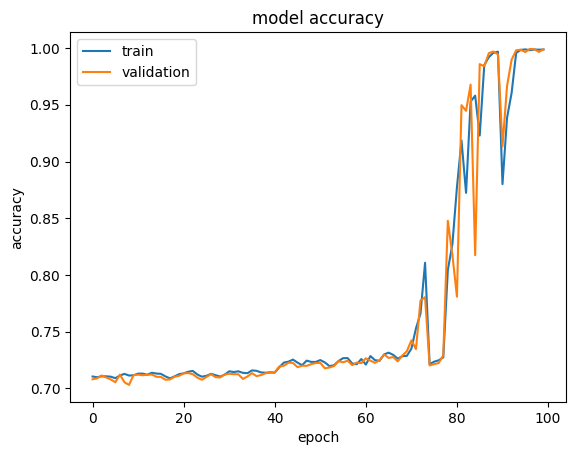

In [96]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


### 📉 Model Loss Visualization

This plot shows how the model's loss changes over each training epoch:

- **Blue Line (`loss`)**: Loss on the training data.
- **Orange Line (`val_loss`)**: Loss on the validation data.

#### 📌 Interpretation:
- A **decreasing training and validation loss** means the model is learning.
- If **validation loss increases while training loss decreases**, the model may be **overfitting**.
- Ideally, both curves should go down and stay close together.

Visualizing loss helps us understand how well the model is generalizing.

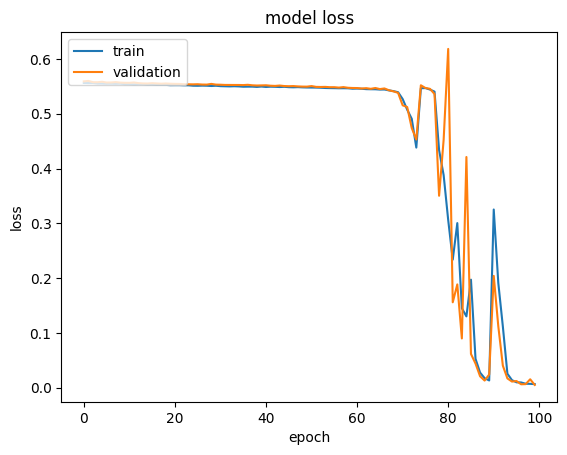

In [97]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [98]:
print(f'the length of y_test {len(y_test)}')
print(f'the length of y_test {len(y_predict)}')

the length of y_test 93906
the length of y_test 93906


### 🔍 Prediction Rounding

The model outputs probabilities between 0 and 1 for each test sample.

We use the following line to convert these probabilities into class predictions:


In [109]:
y_pred = [np.round(i[0]) for i in y_predict]
y_pred

[np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 np.float3

### 📊 Confusion Matrix

To evaluate the performance of the classification model, we use a **confusion matrix**.

The following code computes and displays it:

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt
CM = confusion_matrix(y_test, y_pred)
print('Confusion Matrix is : \n', CM)

Confusion Matrix is : 
 [[47060    27]
 [   45 46774]]


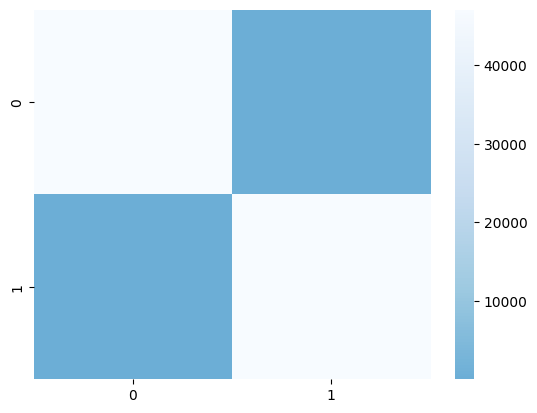

In [114]:
# drawing confusion matrix
sns.heatmap(CM, center = True,cmap='Blues_r')
plt.show()


In [116]:

ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     47087
           1       1.00      1.00      1.00     46819

    accuracy                           1.00     93906
   macro avg       1.00      1.00      1.00     93906
weighted avg       1.00      1.00      1.00     93906

